In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

from pathlib import Path
from model_util import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from neuron_model import *

### Import data

In [3]:
df_Ch001 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch001.pkl"))
df_Ch009 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch009.pkl"))
df_Ch020 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch020.pkl"))
df_Ch022 = pd.read_pickle(Path("C:/Users/Victor/Desktop/PIR/process/Ch022.pkl"))

### train parameters

In [4]:
df_input=[df_Ch001, df_Ch020, df_Ch009]
log_noise=1
network= "cnn"
model= CNN_v2()
batch_size= 512
lr=0.0001
epochs= 1000
patience= 10
savename="CNN"
version="v2_big"

### scaling and formating data to tensor

In [5]:
if network == "fnn":
    data_scaled, target_scaled, output_scaler = FNN_scale_format(df_input, df_Ch022, log_noise=1)
elif network == "cnn":
    data_scaled, target_scaled, output_scaler = CNN_scale_format(df_input, df_Ch022, log_noise=1)

In [6]:
print(data_scaled.shape)

torch.Size([4722, 1, 34, 3])


### split data


In [7]:
size=len(df_Ch022.index)
split=int(size*0.15)

data_train=data_scaled[split:]
target_train=target_scaled[split:]

In [8]:
#split data into train and val, transform all data to pytorch tensor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_train, target_train, test_size=0.15, random_state=10)

print(X_train.shape)
train_size=y_train.shape[0]
val_size=y_val.shape[0]

torch.Size([3411, 1, 34, 3])


In [9]:
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [10]:
trainset = TensorDataset(X_train, y_train)
train_loader = DataLoader(trainset, batch_size=batch_size)
validationset= TensorDataset(X_val, y_val)
val_loader = DataLoader(validationset, batch_size=batch_size)

### CNN model

In [11]:
#defining optimizer and loss, moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

### Training and Evaluating using Ignite

In [12]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [13]:
# defining the number of epochs
epochs = epochs
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'MSE':Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'loss':[]}
validation_history = {'loss':[]}
last_epoch = []

In [14]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

In [15]:
def score_function(engine):
    val_loss = engine.state.metrics['MSE']
    return -val_loss

handler = EarlyStopping(patience=patience, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

In [16]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    loss = metrics['MSE']
    last_epoch.append(0)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    loss = metrics['MSE']
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg loss: {:.2f}"
          .format(trainer.state.epoch, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)  

### model save

In [17]:
checkpointer = ModelCheckpoint(Path('./saved_models'), savename, n_saved=1, create_dir=True, save_as_state_dict=True, require_empty=False)

trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {version : model})

### Run Engine

In [18]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epoch: 1  Avg loss: 0.07
Validation Results - Epoch: 1  Avg loss: 0.07
Training Results - Epoch: 2  Avg loss: 0.05
Validation Results - Epoch: 2  Avg loss: 0.05
Training Results - Epoch: 3  Avg loss: 0.05
Validation Results - Epoch: 3  Avg loss: 0.05
Training Results - Epoch: 4  Avg loss: 0.03
Validation Results - Epoch: 4  Avg loss: 0.03
Training Results - Epoch: 5  Avg loss: 0.03
Validation Results - Epoch: 5  Avg loss: 0.03
Training Results - Epoch: 6  Avg loss: 0.02
Validation Results - Epoch: 6  Avg loss: 0.02
Training Results - Epoch: 7  Avg loss: 0.02
Validation Results - Epoch: 7  Avg loss: 0.02
Training Results - Epoch: 8  Avg loss: 0.02
Validation Results - Epoch: 8  Avg loss: 0.02
Training Results - Epoch: 9  Avg loss: 0.02
Validation Results - Epoch: 9  Avg loss: 0.02
Training Results - Epoch: 10  Avg loss: 0.02
Validation Results - Epoch: 10  Avg loss: 0.02
Training Results - Epoch: 11  Avg loss: 0.02
Validation Results - Epoch: 11  Avg loss: 0.02
Traini

State:
	iteration: 490
	epoch: 70
	epoch_length: 7
	max_epochs: 1000
	output: 0.010112220421433449
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plotting the loss and accuracy

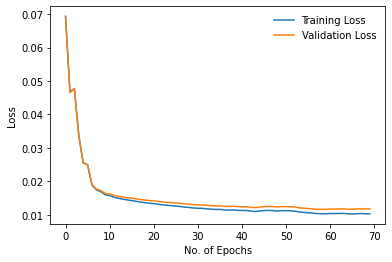

In [19]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()